# LABORATORIO 4
HELLEN CARRANZA- IA

# Entrenamiento de un Detector de Objetos Personalizado usando YOLOv5

Entrenaremos un modelo YOLOv5 *medium* para detectar **Drones**.

<img src="https://opencv.org/wp-content/uploads/2022/08/drone-detection-yolov5-custom-data.jpg" alt="YOLOv5 custom training">


## 1. Configuración de dependencias y entorno


In [ ]:
# librerías necesarias
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

# Clonar el repositorio de YOLOv5 y instalar dependencias
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
import torch
from IPython.display import Image, clear_output
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0 ).name if torch.cuda.is_available() else 'CPU'})")


Cloning into 'yolov5'...
remote: Enumerating objects: 17521, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 17521 (delta 9), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17521/17521), 16.61 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (11998/11998), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 

## 2. Preparación y descarga del conjunto de datos

Utilizaremos el conjunto de datos <a href="https://www.kaggle.com/datasets/sshikamaru/drone-yolo-detection" target="_blank">Drone-dataset</a> de Kaggle para entrenar el detector de objetos YOLOv5 personalizado. Hemos recortado el conjunto de datos y mejorado las anotaciones para un entrenamiento más rápido y mejor. Nuestro conjunto de datos contiene 526 imágenes, divididas en conjuntos de entrenamiento (70% ), validación (10%) y prueba (20%).


In [ ]:
# Descargar y descomprimir el dataset

if not os.path.exists("/content/drone.zip"):
    !curl -L "https://www.dropbox.com/sh/he3b4skcbvp1625/AAD0FJiGmBkQfSPtvG4yTF81a?dl=1" > /content/drone.zip


%cd /content/


!unzip -o drone.zip

!rm drone.zip


%cd /content/yolov5

print("Descarga y descompresión del dataset completadas." )

if os.path.exists("/content/train") and os.path.exists("/content/valid") and os.path.exists("/content/test"):
    print("Los directorios del dataset (train, valid, test) se han creado correctamente.")
else:
    print("Advertencia: Algunos directorios del dataset no se encontraron. Revisa la descompresión.")


/content
Archive:  drone.zip
mapname:  conversion of  failed
   creating: test/
   creating: train/
   creating: valid/
 extracting: data.yaml               
   creating: inference/
   creating: test/images/
   creating: test/labels/
   creating: train/images/
   creating: train/labels/
   creating: valid/images/
   creating: valid/labels/
 extracting: inference/drone-test3.jpg  
 extracting: inference/drone-test2.jpg  
 extracting: inference/drone-test1.jpg  
 extracting: test/images/49_JPEG.rf.8c2f0608750c9deb68c9e8332869beeb.jpg  
 extracting: test/images/79_JPEG.rf.91ae3ed6100ed7e4125f80583fecb259.jpg  
 extracting: test/labels/49_JPEG.rf.8c2f0608750c9deb68c9e8332869beeb.txt  
 extracting: test/labels/79_JPEG.rf.91ae3ed6100ed7e4125f80583fecb259.txt  
 extracting: train/images/4_JPEG.rf.bdd71f3ff25bde171f5af1c3fb0fe1d7.jpg  
 extracting: train/images/2_JPEG.rf.298d15051064e81d61723780fa40db79.jpg  
 extracting: train/labels/4_JPEG.rf.bdd71f3ff25bde171f5af1c3fb0fe1d7.txt  
 extractin

El conjunto de datos está estructurado de la siguiente manera:



### El archivo YAML del conjunto de datos (`data.yaml`)

El archivo YAML del conjunto de datos (`data.yaml`) que contiene la ruta a las imágenes y etiquetas de entrenamiento y validación ya está proporcionado. Este archivo también contendrá los nombres de las clases del conjunto de datos. El conjunto de datos de drones contiene 1 clase: **'drone'**.

El siguiente bloque muestra el contenido del archivo `data.yaml`.


In [ ]:

%cat ../data.yaml


train: ../train/images
test: ../test/images
val: ../valid/images

nc: 1
names: ['drone']

## 3. Visualización de datos y anotaciones

Antes de continuar, veamos algunas de las imágenes con sus anotaciones. Las anotaciones actuales en los archivos de texto están en formato normalizado `[x_center, y_center, width, height]`. Escribamos una función que las convierta de nuevo al formato `[x_min, y_min, x_max, y_max]`.


In [ ]:

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax


In [ ]:
class_names = ['drone']


La siguiente función `plot_box()` dibuja el cuadro delimitador alrededor de los objetos de acuerdo con los datos anotados.


In [ ]:
def plot_box(image, bboxes, labels):

    h, w = image.shape[:2]

    for box_num, box in enumerate(bboxes):

        x1, y1, x2, y2 = yolo2bbox(box)

        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]


        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(0,0,255), thickness=max(2, int(w/275)))


        font_scale = min(1, max(4,int(w/500)))
        font_thickness = min(1, max(10,int(w/50)))
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]

        p2 = p1[0] + tw, p1[1] + -th - 10

        cv2.rectangle(image, p1, p2, color=(255,0,0), thickness=-1)
        cv2.putText(image, class_name, (xmin+1, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return image


### Función para visualizar imágenes aleatorias con los cuadros delimitadores


In [ ]:
def visualize(image_paths, label_paths, num_samples):

    all_training_images = glob.glob(os.path.join('..', image_paths))
    all_training_labels = glob.glob(os.path.join('..', label_paths))
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(20, 17))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


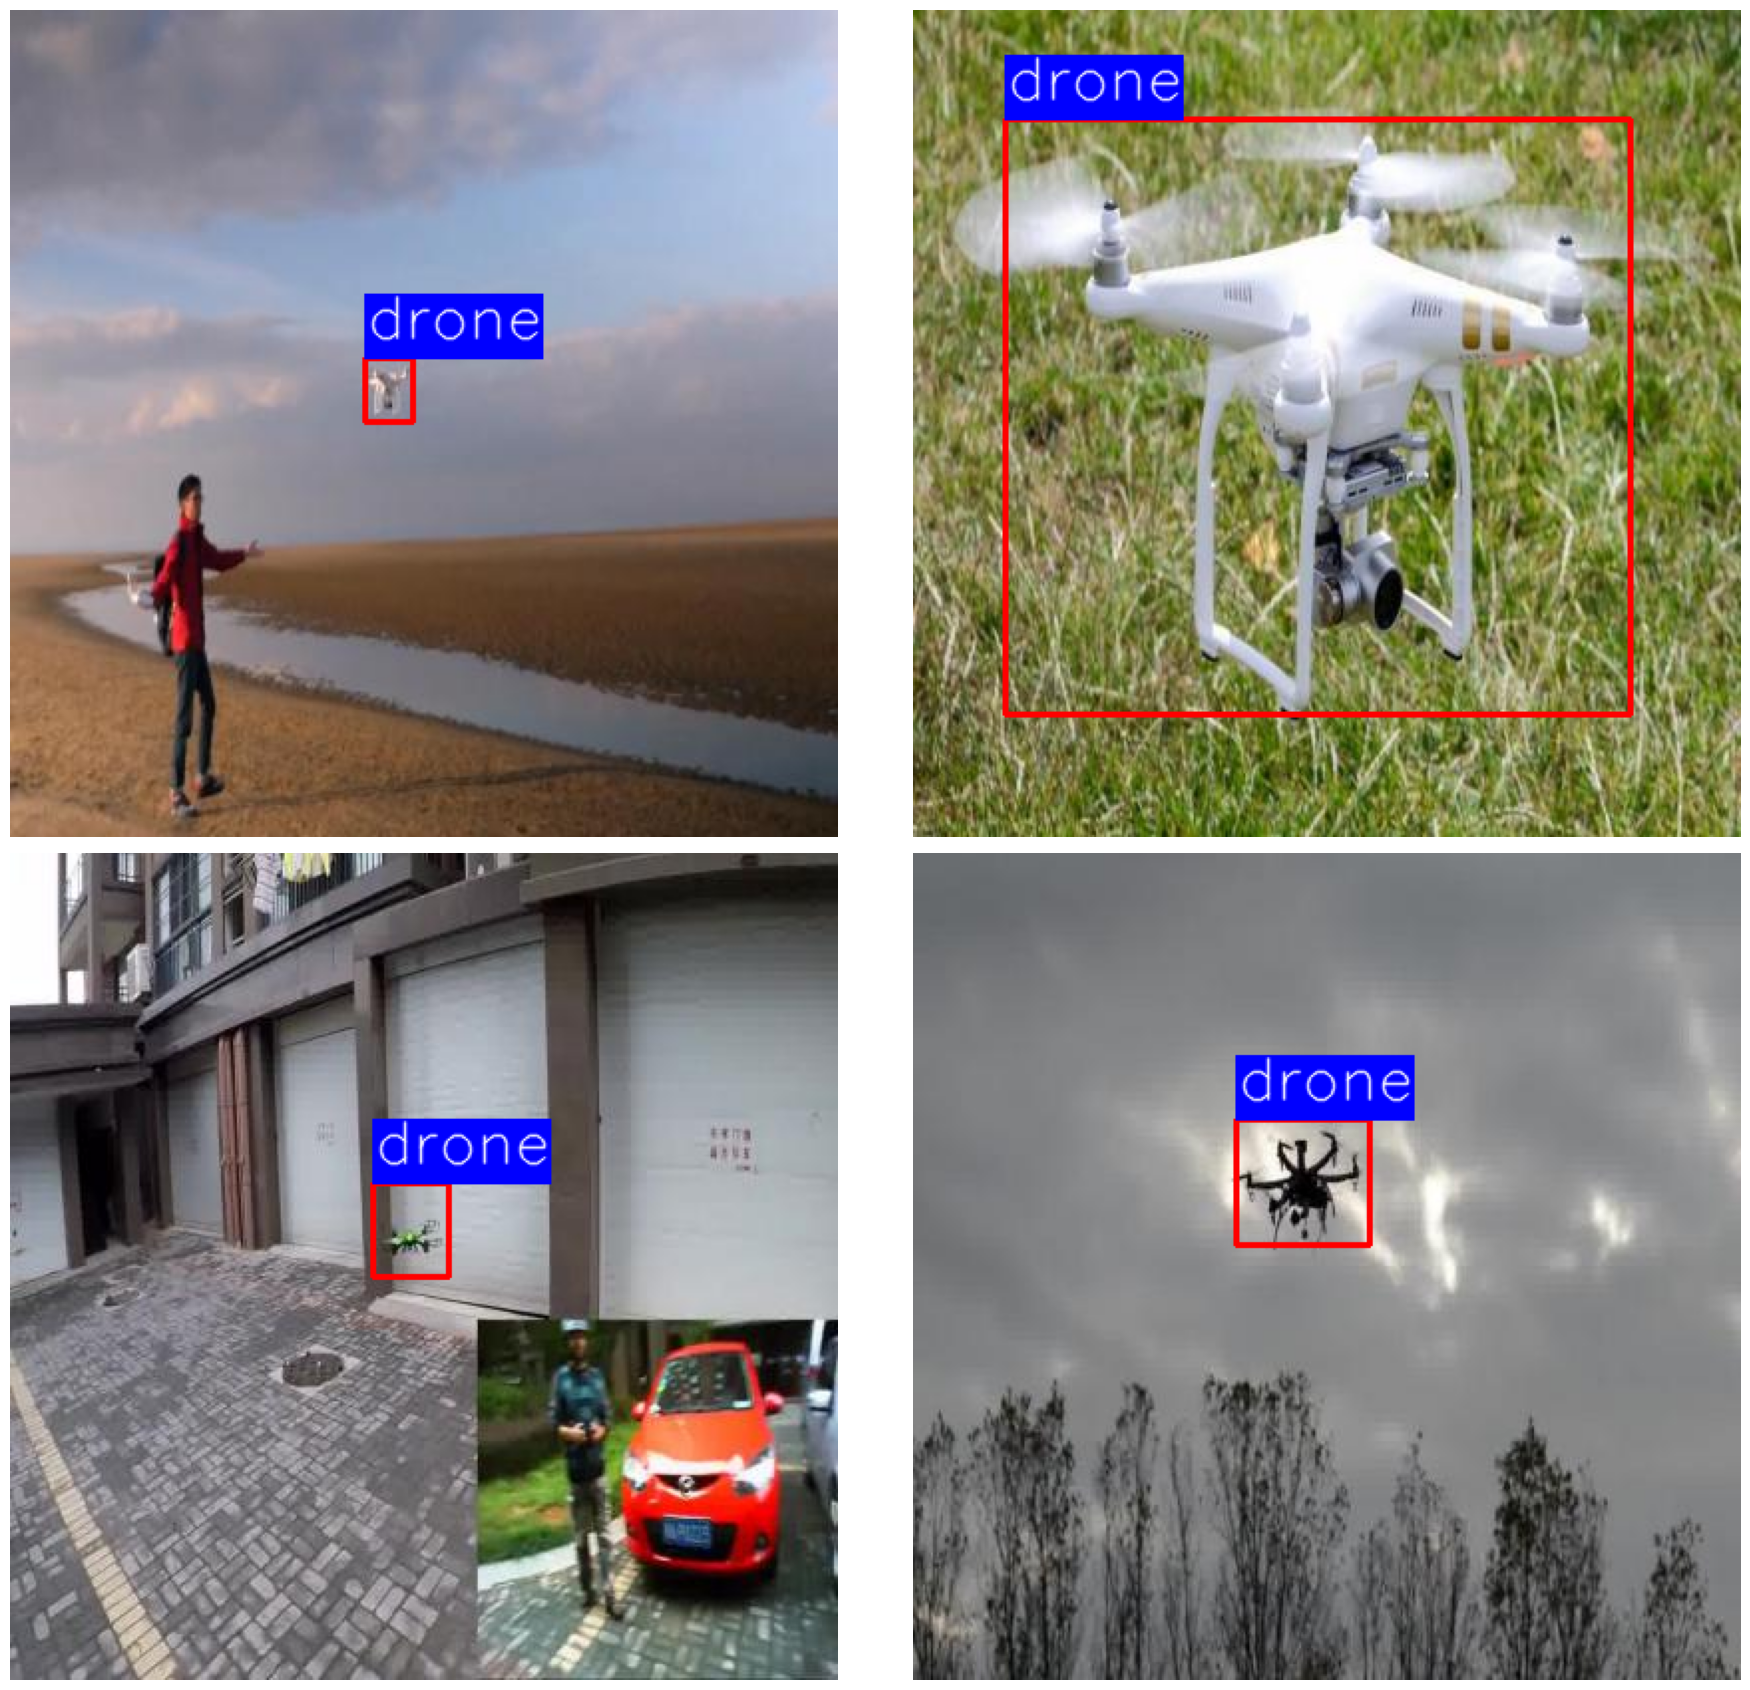

In [ ]:
# Visualizar 4 imágenes de ejemplo del conjunto de entrenamiento
visualize(image_paths='train/images/*', label_paths='train/labels/*', num_samples=4)


## 4. Entrenamiento del modelo YOLOv5



In [ ]:
# Iniciar el entrenamiento


!python train.py --img 640 --batch 16 --epochs 100 --data ../data.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt --name yolov5m_drone_detection --cache


Se han truncado las últimas 5000 líneas del flujo de salida.
       5/99       7.1G    0.05169    0.01707          0         35        640:  92% 22/24 [00:08<00:00,  2.58it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/99       7.1G    0.05141    0.01695          0         28        640:  96% 23/24 [00:09<00:00,  2.58it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/99       7.1G    0.05114    0.01662          0          7        640: 100% 24/24 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:00<00:00,  2.26it/s]
                   all         64         67      0.537      0.716      0.619      0.275

  

## 5. Inferencia y prueba del modelo entrenado



In [ ]:

!python detect.py --weights runs/train/yolov5m_drone_detection/weights/best.pt --source ../test/images --imgsz 640 --conf-thres 0.25 --name inference_results_drones


detect: weights=['runs/train/yolov5m_drone_detection/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_results_drones, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/89 /content/test/images/113_JPEG.rf.ea3ddbe0cc4b2e9841261b289bc13298.jpg: 640x640 2 drones, 27.0ms
image 2/89 /content/test/images/120_JPEG.rf.a7662dd1b5b418a0be2ec729bcc24346.jpg: 640x640 1 drone, 27.1ms
image 3/89 /content/test/images/176_JPEG.rf.9e660d17b8900f79cb

### Visualizar resultados de la inferencia

Podemos visualizar algunas de las imágenes con las detecciones realizadas por el modelo.


Mostrando imagen de ejemplo: runs/detect/inference_results_drones/video17_643_JPEG.rf.291aed34e5b5bf332cfbeb8d1d5fb6bd.jpg


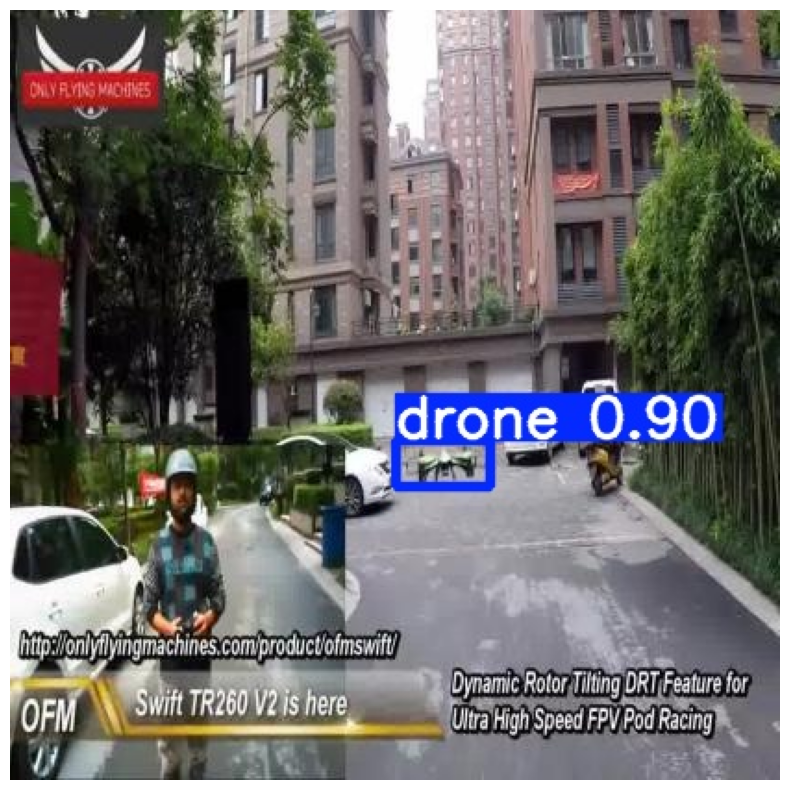

In [ ]:


import glob
import matplotlib.pyplot as plt
import cv2


inference_output_dir = 'runs/detect/inference_results_drones/'

detected_images = glob.glob(os.path.join(inference_output_dir, '*.jpg')) + glob.glob(os.path.join(inference_output_dir, '*.png'))

if len(detected_images) > 0:

    sample_image_path = detected_images[0]
    print(f"Mostrando imagen de ejemplo: {sample_image_path}")
    img = cv2.imread(sample_image_path)
    plt.figure(figsize=(15, 10))
    plt.imshow(img[:, :, ::-1])
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes detectadas en el directorio de salida.")
